# Predictive Modeling

In [1]:
!pip install google-cloud-bigquery google-cloud-storage
!pip install xgboost scikit-learn bayesian-optimization
!pip install shap xgboost
!pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Initialize BigQuery client
project_id = "bigdatabowl2025"
client = bigquery.Client(project=project_id, location='us-central1')

# Loading final_df after initial runs

In [4]:
# Define your query
query = """
SELECT * FROM `bigdatabowl2025.bdb_tables.final_aggregated_data`
"""

# Execute the query and convert the result to a DataFrame
final_df = client.query(query).to_dataframe()

pd.set_option('display.max_columns', None)
# Display the first few rows
print(final_df.shape)
print(final_df.head())


(15903, 34)
       gameId  playId  target_rush   qb_depth  rb_depth  fb_depth  \
0  2022091100    4068            0  14.990002  9.990002       0.0   
1  2022091100    4131            0   1.129998  6.469998       0.0   
2  2022091101    4128            0   0.949999  4.139999       0.0   
3  2022091101    4174            0   1.040001  4.080001       0.0   
4  2022091103    5120            0   1.069999  3.699999       0.0   

   absoluteYardlineNumber  preSnapHomeTeamWinProbability  \
0                      70                       0.434159   
1                      77                       0.439419   
2                      59                       0.462624   
3                      50                       0.465353   
4                      75                       0.330262   

   preSnapVisitorTeamWinProbability offenseFormation receiverAlignment  \
0                          0.565841               NA                NA   
1                          0.560581               NA            

In [5]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = [
    "offenseFormation",
    "receiverAlignment",
    "pff_passCoverage",
    "pff_manZone",
    "possessionTeam",
    "week"
]

# Initialize LabelEncoder for each column
label_encoders = {}
for column in columns_to_encode:
    le = LabelEncoder()
    # Fill NaN with a placeholder string before encoding
    final_df[column] = final_df[column].fillna("NA")
    final_df[column] = le.fit_transform(final_df[column])
    label_encoders[column] = le  # Store the encoder for potential inverse transformation

# Verify encoded DataFrame
print(final_df[columns_to_encode].head())


   offenseFormation  receiverAlignment  pff_passCoverage  pff_manZone  \
0                 3                 10                15            1   
1                 3                 10                15            1   
2                 3                 10                15            1   
3                 3                 10                15            1   
4                 3                 10                15            1   

   possessionTeam  week  
0              22     0  
1              22     0  
2               7     0  
3               7     0  
4              26     0  


In [6]:
print(final_df.dtypes)

gameId                                Int64
playId                                Int64
target_rush                           Int64
qb_depth                            float64
rb_depth                            float64
fb_depth                            float64
absoluteYardlineNumber                Int64
preSnapHomeTeamWinProbability       float64
preSnapVisitorTeamWinProbability    float64
offenseFormation                      int64
receiverAlignment                     int64
pff_passCoverage                      int64
pff_manZone                           int64
homeTeamPossession                    Int64
quarter                               Int64
down                                  Int64
yardsToGo                             Int64
gameClock                            object
possessionTeam                        int64
preSnapHomeScore                      Int64
preSnapVisitorScore                   Int64
RB_snap_motion                        Int64
WR_snap_motion                  

In [7]:
def convert_game_clock(clock):
    mins, secs = map(int, clock.split(":"))
    return mins * 60 + secs

final_df['gameClock_seconds'] = final_df['gameClock'].apply(convert_game_clock)
final_df = final_df.drop(columns=['gameClock'])


In [8]:
print(final_df.isnull().sum())


gameId                              0
playId                              0
target_rush                         0
qb_depth                            0
rb_depth                            0
fb_depth                            0
absoluteYardlineNumber              0
preSnapHomeTeamWinProbability       0
preSnapVisitorTeamWinProbability    0
offenseFormation                    0
receiverAlignment                   0
pff_passCoverage                    0
pff_manZone                         0
homeTeamPossession                  0
quarter                             0
down                                0
yardsToGo                           0
possessionTeam                      0
preSnapHomeScore                    0
preSnapVisitorScore                 0
RB_snap_motion                      0
WR_snap_motion                      0
FB_snap_motion                      0
TE_snap_motion                      0
RB_motion                           0
WR_motion                           0
FB_motion   

In [9]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = final_df.drop(columns=['target_rush', 'gameId', 'playId', ])
y = final_df['target_rush']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (12722, 31), Test shape: (3181, 31)


In [10]:
final_df.to_csv("preprocessed_modeling_data.csv", index=False)


In [11]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
xgb.set_config(verbosity=0)

# Define Bayesian Optimization for XGBoost
def xgb_cv(max_depth, learning_rate, n_estimators, colsample_bytree, subsample):
    model = xgb.XGBClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_result = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
    return cv_result.mean()

# Parameter bounds for optimization
param_bounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 500),
    'colsample_bytree': (0.3, 0.9),
    'subsample': (0.5, 1.0)
}

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.8216    | 0.5622    | 0.2857    | 8.124     | 319.4     | 0.4092    |
| 2         | 0.8546    | 0.4092    | 0.02684   | 9.063     | 320.5     | 0.7957    |
| 3         | 0.8163    | 0.3144    | 0.2913    | 8.827     | 145.6     | 0.4273    |
| 4         | 0.8511    | 0.4284    | 0.09823   | 6.673     | 244.4     | 0.5039    |
| 5         | 0.8575    | 0.7283    | 0.05045   | 5.045     | 214.9     | 0.6192    |
| 6         | 0.854     | 0.7611    | 0.03192   | 5.057     | 214.8     | 0.663     |
| 7         | 0.856     | 0.7064    | 0.07867   | 4.576     | 215.3     | 0.4835    |
| 8         | 0.8572    | 0.5037    | 0.05368   | 5.976     | 215.5     | 0.9469    |
| 9         | 0.8477    | 0.6214    | 0.1677    | 5.496     | 215.5     | 0.5753    |
| 10        | 0.8469    | 0.3353    | 0.1278    | 6.07

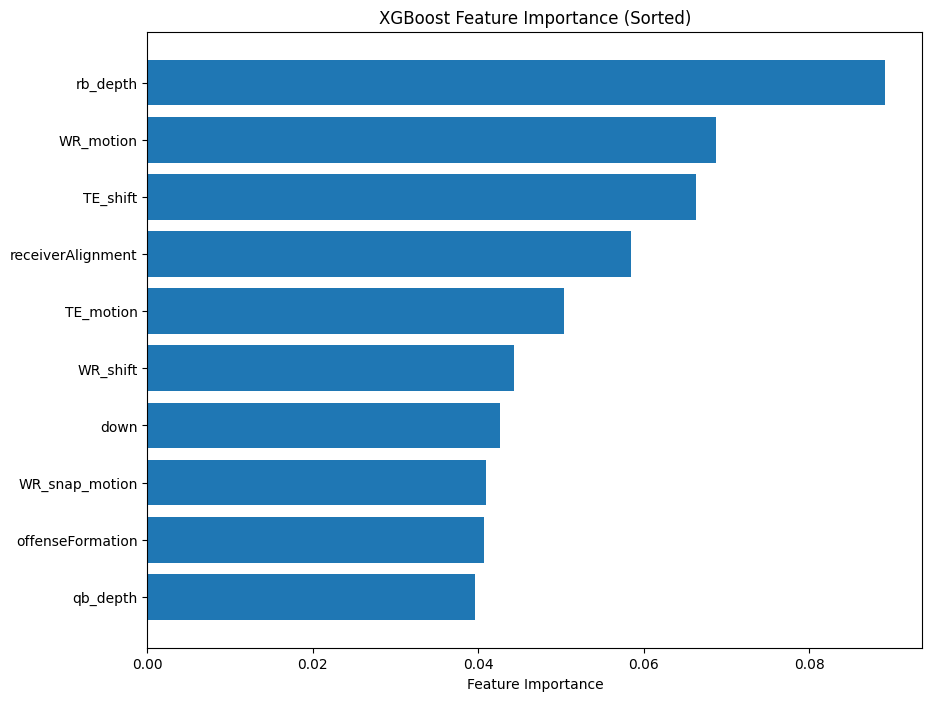

In [12]:
from xgboost import XGBClassifier, cv, DMatrix
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import numpy as np

# Define Cross-Validation Function for Bayesian Optimization
def xgb_cv(max_depth, learning_rate, n_estimators, colsample_bytree, subsample):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    # Initialize the model
    model = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    # Use cross-validation to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc")
    return scores.mean()

# Parameter bounds for Bayesian Optimization
param_bounds = {
    "max_depth": (3, 10),
    "learning_rate": (0.01, 0.3),
    "n_estimators": (50, 500),
    "colsample_bytree": (0.3, 1.0),
    "subsample": (0.3, 1.0),
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_cv, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

# Extract best parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# Train final XGBoost model with optimized parameters
final_model = XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    use_label_encoder=False,
    eval_metric="logloss"
)

final_model.fit(X_train, y_train)

# Get feature importance
import matplotlib.pyplot as plt
xgb_importances = final_model.feature_importances_

# Sort features and importances in descending order
sorted_indices = np.argsort(xgb_importances)[::-1]  # Sort indices in descending order
sorted_features = X_train.columns[sorted_indices]
sorted_importances = xgb_importances[sorted_indices]

# Plot feature importance in descending order
plt.figure(figsize=(10, 8))
plt.barh(sorted_features[:10], sorted_importances[:10])  # Display top 10 features
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

# Select the top 10 features
top_features = sorted_features[:10]
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


In [13]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score

# Train LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_top, y_train)

# Predictions
y_pred_lgb = lgb_model.predict(X_test_top)
y_pred_lgb_proba = lgb_model.predict_proba(X_test_top)[:, 1]

# Evaluate LightGBM
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_test, y_pred_lgb_proba)
print(f"LightGBM Accuracy: {accuracy_lgb}")
print(f"LightGBM ROC-AUC: {roc_auc_lgb}")

# Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_top, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_top)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_top)[:, 1]

# Evaluate XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)
print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f"XGBoost ROC-AUC: {roc_auc_xgb}")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 5211, number of negative: 7511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 12722, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409605 -> initscore=-0.365597
[LightGBM] [Info] Start training from score -0.365597
LightGBM Accuracy: 0.7613957874882112
LightGBM ROC-AUC: 0.8301844110433717
XGBoost Accuracy: 0.7491354919836529
XGBoost ROC-AUC: 0.8181164197070878


In [14]:
results = {
    "Model": ["LightGBM", "XGBoost"],
    "Accuracy": [accuracy_lgb, accuracy_xgb],
    "ROC-AUC": [roc_auc_lgb, roc_auc_xgb]
}

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

      Model  Accuracy   ROC-AUC
0  LightGBM  0.761396  0.830184
1   XGBoost  0.749135  0.818116


In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_search_lgb = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1
)

grid_search_lgb.fit(X_train_top, y_train)
print(f"Best LightGBM Params: {grid_search_lgb.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 4168, number of negative: 6009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 10177, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409551 -> initscore=-0.365822
[LightGBM] [Info] Start training from score -0.365822
[LightGBM] [Info] Number of positive: 4169, number of negative: 6008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set

In [16]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_distributions=param_grid_xgb,
    scoring='roc_auc',
    n_iter=20,
    cv=5,
    verbose=1
)

random_search_xgb.fit(X_train_top, y_train)
print(f"Best XGBoost Params: {random_search_xgb.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [17]:
# Step 1: Store models and their metrics
models = {
    "LightGBM": {"model": lgb_model, "accuracy": accuracy_lgb, "roc_auc": roc_auc_lgb},
    "XGBoost": {"model": xgb_model, "accuracy": accuracy_xgb, "roc_auc": roc_auc_xgb}
}

# Step 2: Determine the best model based on ROC-AUC
best_model_name = max(models, key=lambda k: models[k]["roc_auc"])  # Select model with the highest ROC-AUC
final_model = models[best_model_name]["model"]

print(f"The best model is: {best_model_name} with ROC-AUC: {models[best_model_name]['roc_auc']}")

# Step 3: Use the winning model for predictions
y_pred_final = final_model.predict(X_test_top)
y_pred_final_proba = final_model.predict_proba(X_test_top)[:, 1]

# Step 4: Evaluate the final model on the test set
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

accuracy_final = accuracy_score(y_test, y_pred_final)
roc_auc_final = roc_auc_score(y_test, y_pred_final_proba)

print(f"Final Model Test Accuracy: {accuracy_final}")
print(f"Final Model Test ROC-AUC: {roc_auc_final}")
print("Classification Report:")
print(classification_report(y_test, y_pred_final))

The best model is: LightGBM with ROC-AUC: 0.8301844110433717
Final Model Test Accuracy: 0.7613957874882112
Final Model Test ROC-AUC: 0.8301844110433717
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1886
           1       0.73      0.66      0.69      1295

    accuracy                           0.76      3181
   macro avg       0.75      0.75      0.75      3181
weighted avg       0.76      0.76      0.76      3181



In [18]:
import joblib
joblib.dump(final_model, 'final_lightgbm_model.pkl')

['final_lightgbm_model.pkl']

Accuracy: 0.7613957874882112
ROC-AUC: 0.8301844110433717


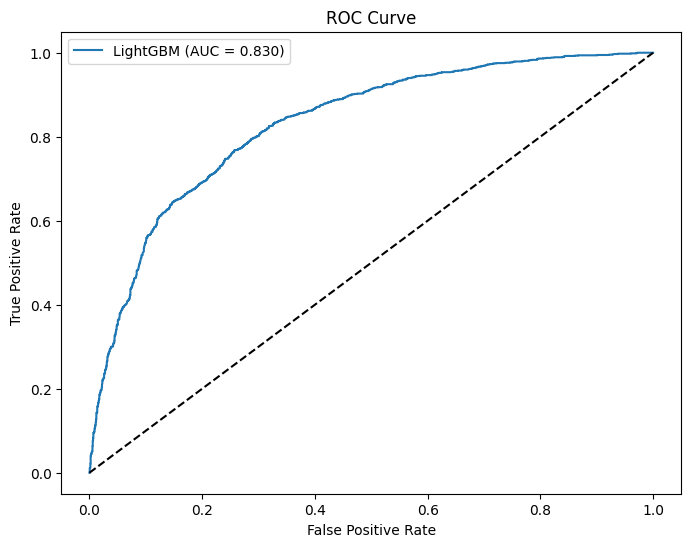

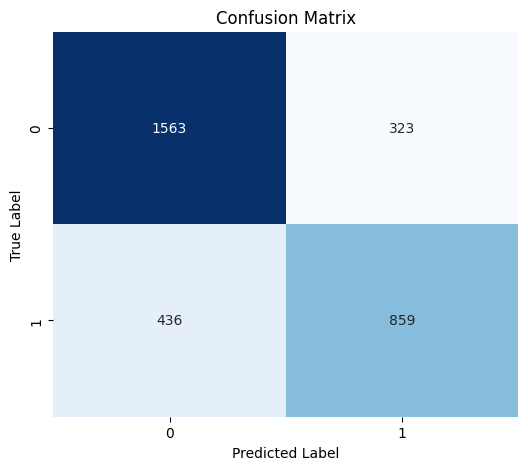

In [19]:
import seaborn as sns

# Evaluation Metrics
conf_matrix = confusion_matrix(y_test, y_pred_final)

print(f"Accuracy: {accuracy_final}")
print(f"ROC-AUC: {roc_auc_final}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_final_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="LightGBM (AUC = {:.3f})".format(roc_auc_final))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


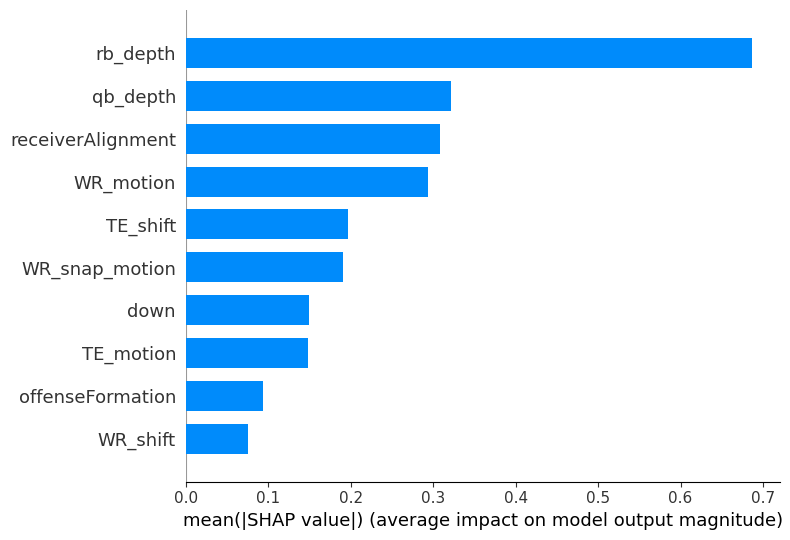

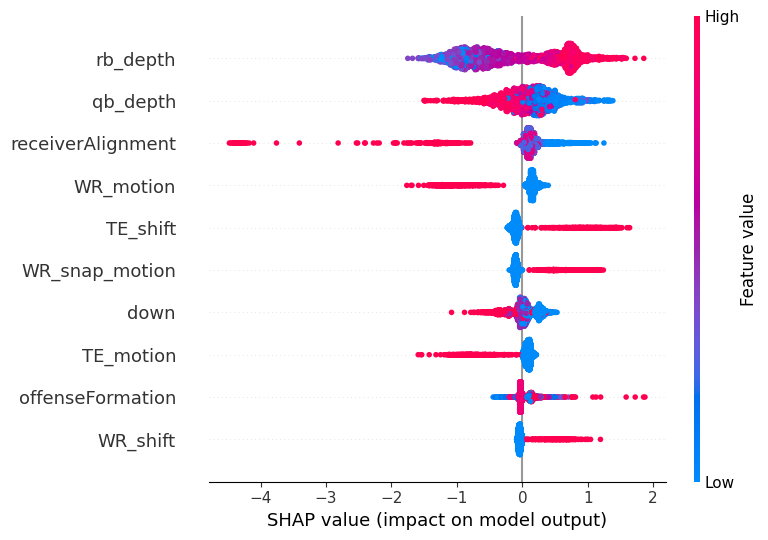

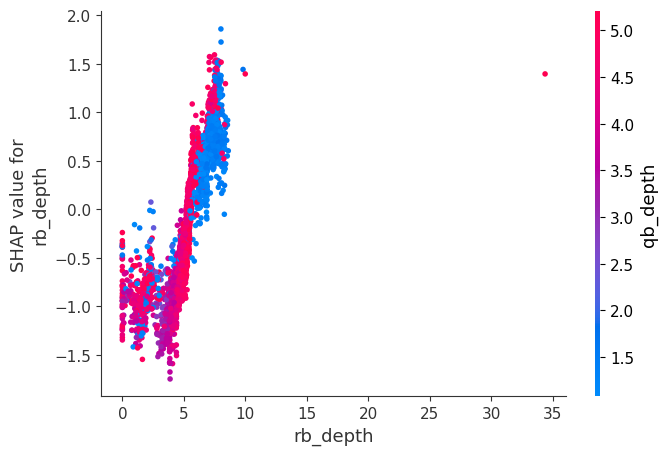

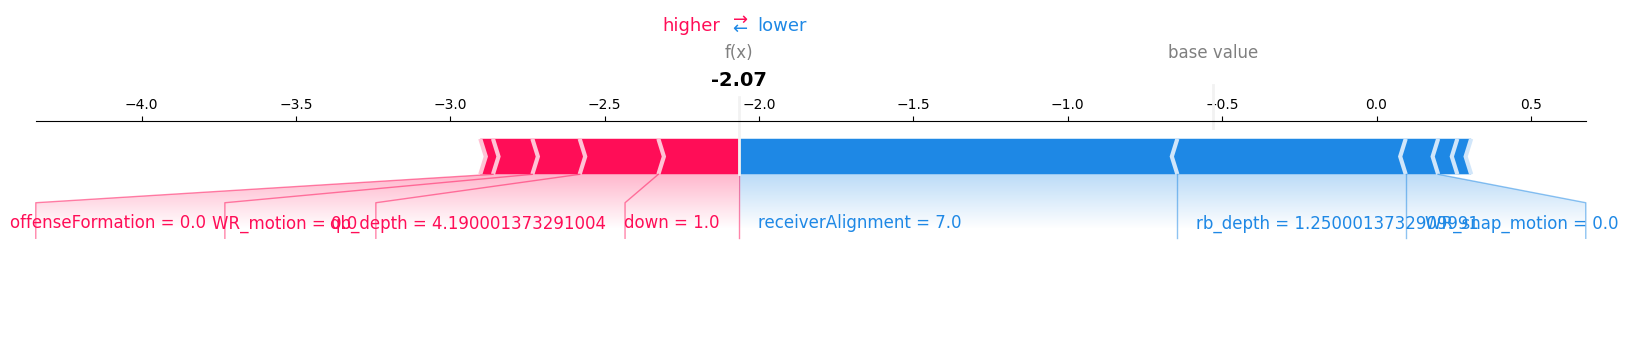

In [20]:
# Step 1: Initialize the SHAP Explainer for LightGBM
explainer = shap.TreeExplainer(final_model)

# Step 2: Compute SHAP Values for the Test Data
shap_values = explainer.shap_values(X_test_top)

# Step 3: Summary Plot (Global Feature Importance)
# Visualize global feature importance across the dataset
shap.summary_plot(shap_values, X_test_top, plot_type="bar")

# Step 4: Detailed Summary Plot
# Shows the distribution of SHAP values for each feature
shap.summary_plot(shap_values, X_test_top)

# Step 5: Dependence Plot for 'rb_depth' vs. 'target_rush'
# Ensure 'rb_depth' is a feature in X_test_top
if 'rb_depth' in X_test_top.columns:
    shap.dependence_plot('rb_depth', shap_values, X_test_top)
else:
    print("Feature 'rb_depth' not found in the test dataset.")

# Step 6: Force Plot (Individual Prediction)
# Ensure compatibility with scalar expected_value
shap.force_plot(
    explainer.expected_value,  # Scalar expected value
    shap_values[0],            # SHAP values for the first row
    X_test_top.iloc[0, :],     # First row of test data
    matplotlib=True
)